In [1]:
%matplotlib inline
from structurefunction import structure_function
import numpy as np
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import astropy.units as u
import os
import shutil

The second-order structure function of rotation measure (RM) is given by:

$$ SF_{\text{RM},\text{obs}}(\delta\theta) = \langle[\text{RM}{\theta} - \text{RM}(\theta+\delta\theta)]^2\rangle$$

That is, the ensemble average of the squared-difference in RM for sources with angular seperation $\delta\theta$. We also need to correct for the impact of errors by:

$$ SF_{\text{RM}}(\delta\theta) = SF_{\text{RM},\text{obs}}(\delta\theta) - SF_{\sigma_\text{RM}}(\delta\theta) $$

See Haverkorn et al. 2004 (2004ApJ...609..776H) for details.

Here we'll reproduce the results of Mao et al. 2010 (2010ApJ...714.1170M).

First, we can look at the expected results. I've pulled these data from the paper's plots using a web plot digitiser.

In [2]:
mao_sf = 10**np.array([2.417894195735458,
                    2.097768739428083,
                    2.2926445508823967,
                    2.164149088774578,
                    2.1404402085381147,
                    2.176621779798478,
                    2.218782670913379,
                    2.2444782900152482,
                    2.2476963207124476,
                    2.2837806390213578,]) * (u.rad / u.m**2)**2
mao_sep = 10**np.array([-0.7729091483767441, 
                    -0.5386163683663935, 
                    -0.2730532911440767, 
                    -0.02550632317850443, 
                    0.21819567988496358, 
                    0.47213008276920787, 
                    0.7173429798998987, 
                    0.9643533199726302, 
                    1.18882007856649, 
                    1.3453070240944185,]) * u.deg

Text(0, 0.5, 'RM SF [$\\mathrm{rad^{2}\\,m^{-4}}$]')

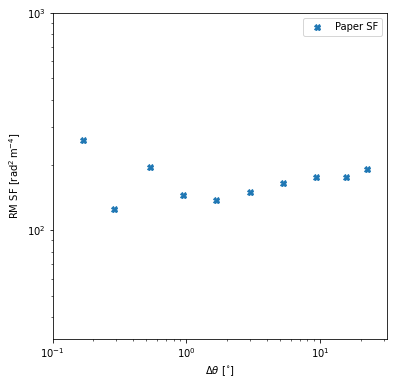

In [3]:
plt.figure(figsize=(6,6))
plt.plot(mao_sep, mao_sf, 'X', label='Paper SF')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**1.5, 10**3)
plt.xlim(10**-1,10**1.5)
plt.legend()
plt.xlabel(rf"$\Delta\theta$ [{mao_sep.unit:latex_inline}]")
plt.ylabel(rf"RM SF [{mao_sf.unit:latex_inline}]")

Now we'll start with the original data. We'll convert the data to an astropy table for convenience

In [4]:
with open('apj343194t1_mrt.txt') as f:
    lines = f.readlines()
for i, line in enumerate(tqdm(lines)):
    lines[i] = line.strip()
coords, rms, e_rms, flags, incs = [], [], [], [], []
for i, line in enumerate(tqdm(lines)):
    ra = f"{line[0:2]}h{line[3:5]}m{line[6:11]}s"
    #print(ra)
    dec = f"{line[12]}{line[13:15]}d{line[16:18]}m{line[19:24]}s"
    coord = SkyCoord(ra, dec)
    rm = float(line[39:42]) * (u.rad / u.m**2)
    e_rm = float(line[43:45]) * (u.rad / u.m**2)
    inc = line[63] == 'Y'
    incs.append(inc)
    try:
        flag = line[67]
    except:
        flag = None
    coords.append(coord)
    rms.append(rm)
    e_rms.append(e_rm)
    flags.append(flag)

mao_rm_tab = Table()
mao_rm_tab.add_column(coords, name='coordinates')
mao_rm_tab.add_column(rms, name='RM')
mao_rm_tab.add_column(e_rms, name='e_RM')
mao_rm_tab.add_column(incs, name='included')
mao_rm_tab.add_column(flags, name='flag')

mao_rm_tab

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

coordinates,RM,e_RM,included,flag
"deg,deg",rad / m2,rad / m2,,
SkyCoord,float64,float64,bool,object
"196.78470833333333,24.78352777777778",-3.0,4.0,True,None
"203.9505833333333,20.171111111111113",3.0,5.0,False,b
"201.06033333333332,22.220305555555555",-6.0,6.0,True,None
"201.07991666666663,22.233472222222222",0.0,6.0,True,None
"199.01816666666664,23.62713888888889",4.0,13.0,True,None
"200.20225,22.965194444444442",-6.0,8.0,True,None
"197.81804166666666,24.454333333333334",5.0,3.0,True,None
"203.60637499999996,21.167916666666667",-1.0,9.0,False,b


Now we'll define our own bin edges to compute a structure function

In [5]:
start = -0.8
stop = 1.5
step = 0.1
bins = 10**np.arange(start, stop+step, step)*u.deg

Here we compute the strcture function itself, including error correction. We use 1000 samples of each distribution for error propagation.

By setting `show_plots=True` three plots are shown. 
1. An error-bar plot of the SF.
2. A count of the number of source pairs per SF bin
3. A structure function image showing the sampling from Monte-Carlo error propagation

The `structure_function` function returns the centre of each bin, the median value of each bin, the upper and lower error bounds, and the number of sources in each bin.

By setting `fit` we use `bilby` to do a best-fit of the SF with a broken power law. Here we're using `nestle` to do the sampling. All `**kwargs` are passed onto the `run_sampler` method of `bilby`.

In [6]:
# Clean up if a previous run was done
if os.path.exists("outdir"):
    shutil.rmtree("outdir")

2022-11-07 14:03:13.640 INFO structurefunction - structure_function: Sampling errors...
2022-11-07 14:03:17.396 INFO structurefunction - structure_function: Getting angular separations...
2022-11-07 14:03:17.434 INFO structurefunction - structure_function: Computing SF...
2022-11-07 14:03:31.302 INFO structurefunction - fit_data: Fitting SF with a broken power law...
14:03 bilby INFO    : Running for label 'broken_power_law_2_point', output will be saved to 'outdir'
14:03 bilby INFO    : Search parameters:
14:03 bilby INFO    :   amplitude = Uniform(minimum=-55.43796027883391, maximum=471.5431939956728, name='amplitude', latex_label='$a$', unit=None, boundary=None)
14:03 bilby INFO    :   x_break = Uniform(minimum=0.179, maximum=28.371000000000002, name='x_break', latex_label='$\\theta_\\mathrm{break}$', unit=None, boundary=None)
14:03 bilby INFO    :   alpha_1 = Uniform(minimum=-2, maximum=2, name='alpha_1', latex_label='$\\alpha_1$', unit=None, boundary=None)
14:03 bilby INFO    :   

it=  3592 logz=-114.816709542922


14:03 bilby INFO    : Sampling time: 0:00:27.098431
14:03 bilby INFO    : Summary of results:
nsamples: 3993
ln_noise_evidence:    nan
ln_evidence: -114.499 +/-  0.130
ln_bayes_factor:    nan +/-  0.130

2022-11-07 14:04:01.465 INFO structurefunction - fit_data: Fitting results:
2022-11-07 14:04:01.467 INFO structurefunction - fit_data: amplitude: 180 ± 10
2022-11-07 14:04:01.468 INFO structurefunction - fit_data: x_break: 22 ± 4
2022-11-07 14:04:01.469 INFO structurefunction - fit_data: alpha_1: 0.11 ± 0.04
2022-11-07 14:04:01.470 INFO structurefunction - fit_data: alpha_2: 0 ± 1
2022-11-07 14:04:01.471 INFO structurefunction - fit_data: Fit log evidence: -114.49868298129567 ± 0.12984044020094218


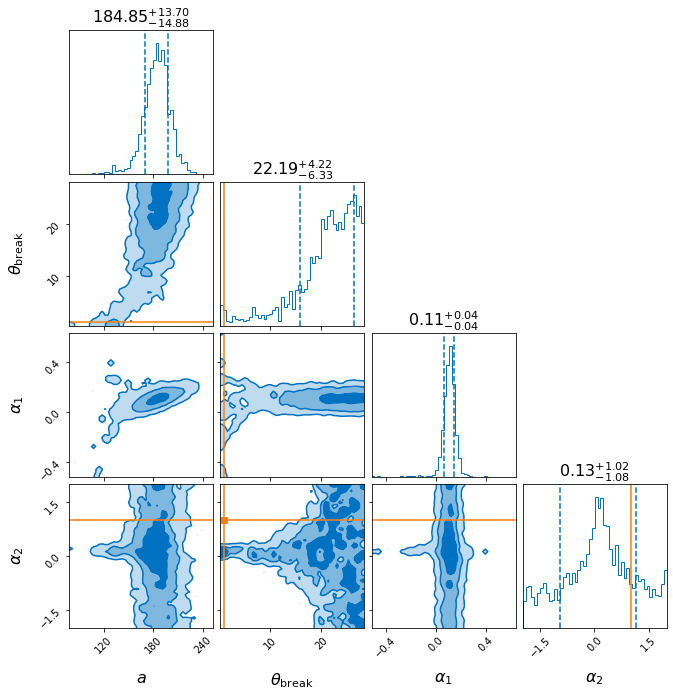

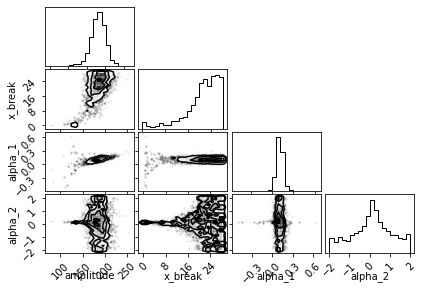

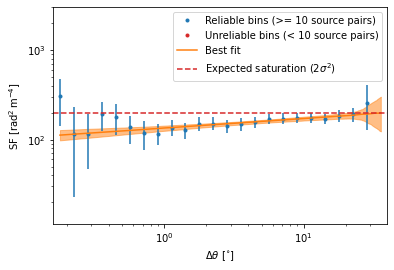

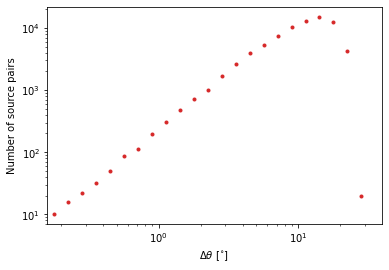

In [7]:
sf_result, result = structure_function(
    data=np.array(mao_rm_tab['RM'][mao_rm_tab['included']]) * u.rad / u.m**2,
    errors=np.array(mao_rm_tab['e_RM'][mao_rm_tab['included']]) * u.rad / u.m**2,
    coords=mao_rm_tab['coordinates'][mao_rm_tab['included']],
    samples=1000,
    bins=bins,
    show_plots=True,
    verbose=True,
    fit='bilby',
    nlive=400,
    sampler='nestle',
    model_name='broken_power_law',
)

2022-11-07 14:04:07.099 INFO structurefunction - structure_function: Sampling errors...
2022-11-07 14:04:09.998 INFO structurefunction - structure_function: Getting angular separations...
2022-11-07 14:04:10.063 INFO structurefunction - structure_function: Computing SF...
2022-11-07 14:04:32.609 INFO structurefunction - fit_data: Fitting SF with a power law...
14:04 bilby INFO    : Running for label 'power_law_2_point', output will be saved to 'outdir'
14:04 bilby INFO    : Search parameters:
14:04 bilby INFO    :   amplitude = Uniform(minimum=-52.035011894175796, maximum=464.9494929780924, name='amplitude', latex_label='$a$', unit=None, boundary=None)
14:04 bilby INFO    :   x_break = Uniform(minimum=0.179, maximum=28.371000000000002, name='x_break', latex_label='$\\theta_\\mathrm{break}$', unit=None, boundary=None)
14:04 bilby INFO    :   alpha = Uniform(minimum=-2, maximum=2, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None)
14:04 bilby INFO    : Single likelihood eva

it=  3219 logz=-114.1911086409369


14:04 bilby INFO    : Sampling time: 0:00:13.769841
14:04 bilby INFO    : Summary of results:
nsamples: 3620
ln_noise_evidence:    nan
ln_evidence: -113.771 +/-  0.124
ln_bayes_factor:    nan +/-  0.124

2022-11-07 14:04:47.401 INFO structurefunction - fit_data: Fitting results:
2022-11-07 14:04:47.402 INFO structurefunction - fit_data: amplitude: 180 ± 20
2022-11-07 14:04:47.403 INFO structurefunction - fit_data: x_break: 15 ± 9
2022-11-07 14:04:47.404 INFO structurefunction - fit_data: alpha: 0.10 ± 0.04
2022-11-07 14:04:47.406 INFO structurefunction - fit_data: Fit log evidence: -113.77116114103981 ± 0.1240670676073616


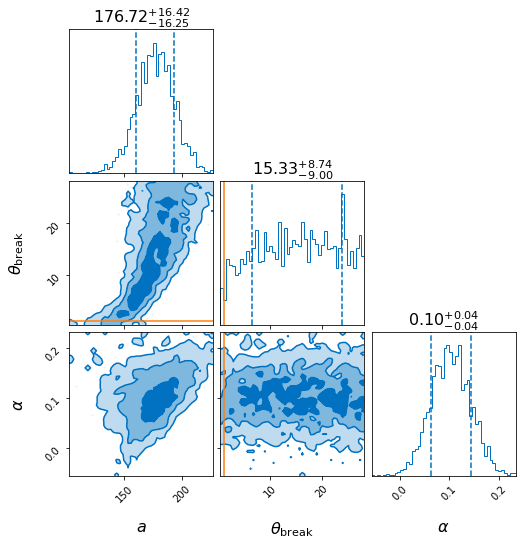

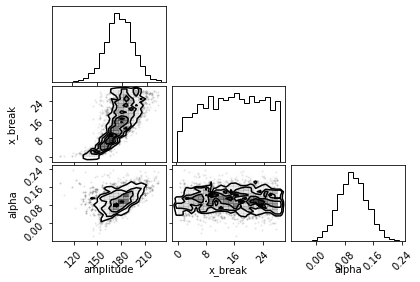

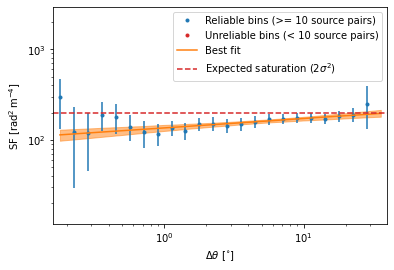

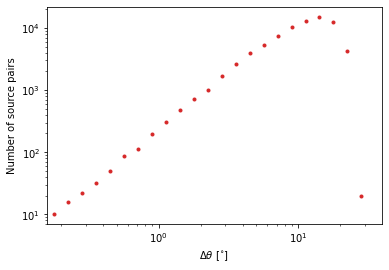

In [8]:
sf_result, result = structure_function(
    data=np.array(mao_rm_tab['RM'][mao_rm_tab['included']]) * u.rad / u.m**2,
    errors=np.array(mao_rm_tab['e_RM'][mao_rm_tab['included']]) * u.rad / u.m**2,
    coords=mao_rm_tab['coordinates'][mao_rm_tab['included']],
    samples=1000,
    bins=bins,
    show_plots=True,
    verbose=True,
    fit='bilby',
    nlive=400,
    sampler='nestle',
    model_name='power_law',
)

We can compare our results to those from the original paper.

Text(0, 0.5, 'RM SF [$\\mathrm{rad^{2}\\,m^{-4}}$]')

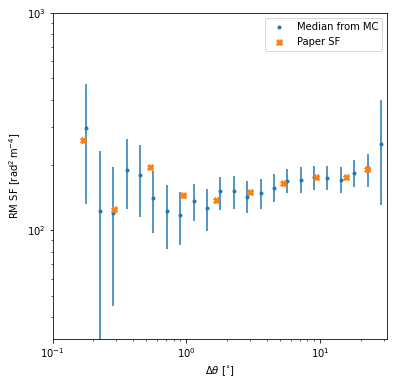

In [9]:
plt.figure(figsize=(6,6), facecolor='w')
plt.plot(sf_result.c_bins, sf_result.med, '.', label='Median from MC')
plt.errorbar(sf_result.c_bins, sf_result.med, yerr=[sf_result.err_low, sf_result.err_high], color='tab:blue', marker=None, fmt=' ', )#label = '16th to 84th percentile range')
plt.plot(mao_sep, mao_sf, 'X', label='Paper SF')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**1.5, 10**3)
plt.xlim(10**-1,10**1.5)
plt.legend()
plt.xlabel(rf"$\Delta\theta$ [{mao_sep.unit:latex_inline}]")
plt.ylabel(rf"RM SF [{mao_sf.unit:latex_inline}]")

Finally, we extend to using mutli-point structure functions, as described by Seta et al. 2022 (10.1093/mnras/stac2972). Currently, only the triple-point structure function is implemented.

In [10]:
sf_result, result = structure_function(
    data=np.array(mao_rm_tab['RM'][mao_rm_tab['included']]) * u.rad / u.m**2,
    errors=np.array(mao_rm_tab['e_RM'][mao_rm_tab['included']]) * u.rad / u.m**2,
    coords=mao_rm_tab['coordinates'][mao_rm_tab['included']],
    samples=1000,
    bins=bins,
    show_plots=True,
    verbose=True,
    fit='bilby',
    nlive=400,
    sampler='nestle',
    model_name='power_law',
    n_point=3
)

2022-11-07 14:04:53.006 INFO structurefunction - structure_function: Sampling errors...
2022-11-07 14:04:55.827 INFO structurefunction - structure_function: Getting angular separations...
2022-11-07 14:04:55.888 INFO structurefunction - structure_function: Computing SF...
2022-11-07 14:05:06.528 INFO structurefunction - flush: Grouping triplets:   0%|          | 0/23 [00:00<?, ?it/s]
2022-11-07 14:05:37.538 INFO structurefunction - flush: Grouping triplets:   4%|4         | 1/23 [00:31<11:22, 31.01s/it]
2022-11-07 14:05:44.894 INFO structurefunction - flush: Grouping triplets:   9%|8         | 2/23 [00:38<05:59, 17.10s/it]
2022-11-07 14:06:03.502 INFO structurefunction - flush: Grouping triplets:  13%|#3        | 3/23 [00:56<05:55, 17.79s/it]
2022-11-07 14:06:03.826 INFO structurefunction - flush: Grouping triplets:  17%|#7        | 4/23 [00:57<03:26, 10.89s/it]
2022-11-07 14:06:44.125 INFO structurefunction - flush: Grouping triplets:  26%|##6       | 6/23 [01:37<04:28, 15.80s/it]
202